# This sample is used to demonstrate the integration of Stereo-seq and Slide-seqV2.

### Step 0：Since Jupyter Notebook does not automatically release GPU memory after running, please run this code to clear all processes occupying GPU memory before the FIRST time starting execution.¶

In [1]:
!fuser -v /dev/nvidia* |awk '{for(i=1;i<=NF;i++)print "kill -9 " $i;}' | sh

Cannot stat file /proc/1137090/fd/0: Permission denied
Cannot stat file /proc/1137090/fd/1: Permission denied
Cannot stat file /proc/1137090/fd/2: Permission denied
Cannot stat file /proc/1137090/fd/3: Permission denied
Cannot stat file /proc/1137090/fd/4: Permission denied
Cannot stat file /proc/1137090/fd/5: Permission denied
Cannot stat file /proc/1137090/fd/8: Permission denied
                     USER        PID ACCESS COMMAND
/dev/nvidia-uvm:     root      mount /dev/nvidia-uvm
/dev/nvidia-uvm-tools:
                     root      mount /dev/nvidia-uvm-tools
/dev/nvidia0:        root      mount /dev/nvidia0
/dev/nvidiactl:      root      mount /dev/nvidiactl
sh: 1: kill: Illegal number: kernelkernelkernelkernel


This sample is used to demonstrate the integration of the Slide-seqV2 and Stereo-seq platforms. Due to the memory limitations of the 3090 GPU, in this sample code, we have uniformly selected 7,000 samples from each dataset.

### Step 1: Load packages

In [2]:
import argparse
import os
os.chdir('/remote-home/13186919777/home/STAIG-test')
import warnings
warnings.filterwarnings('ignore')
import random
import yaml
from yaml import SafeLoader
import torch
from staig.adata_processing import LoadBatchAdata_cross
import numpy as np
from staig.staig import STAIG
import pandas as pd
import scanpy as sc
from sklearn.cluster import KMeans

### Step 2: Load data and train

In [3]:

file_fold = './Dataset'


args = argparse.Namespace(
    slide='integration_cross',
    config='train_img_config.yaml',
    label=False,
)

config = yaml.load(open(args.config), Loader=SafeLoader)[str(args.slide)]


torch.manual_seed(config['seed'])
np.random.seed(config['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed(config['seed'])
    torch.cuda.manual_seed_all(config['seed'])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
random.seed(12345)

data2 = sc.read_h5ad("/remote-home/13186919777/home/STAIG-test/Dataset/Slide-seqV2/v2.h5ad")
data1 = sc.read_h5ad("/remote-home/13186919777/home/STAIG-test/Dataset/stereo-seq/Mouse_Olfactory/filtered_feature_bc_matrix_norm.h5ad") 

np.random.seed(42)

random_obs = np.random.choice(data1.obs_names, size=7000, replace=False)


data1 = data1[random_obs]

random_obs = np.random.choice(data2.obs_names, size=7000, replace=False)



data2 = data2[random_obs]

filelist = [data1,data2]

data = LoadBatchAdata_cross(file_list = filelist,n_neighbors=config['num_neigh'],n_top_genes=config['num_gene'],image_emb=False, label = args.label).run()


staig = STAIG(args=args,config=config,single=True,refine=False)    
staig.adata = data
staig.train()
staig.eva()


View of AnnData object with n_obs × n_vars = 7000 × 27106
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'
    obsm: 'spatial'
View of AnnData object with n_obs × n_vars = 7000 × 11750
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'va

100%|██████████| [00:23<00:00,  7.52it/s]


=== load ===
embedding generated, go clustering


### step 3: Clustering

fitting ...
  |======================================================================| 100%
calculate SC and DB
SC: 0.23544079
DB: 1.2888470334981597
BatchKL= [0.28828174]
Median ILISI: 1.69


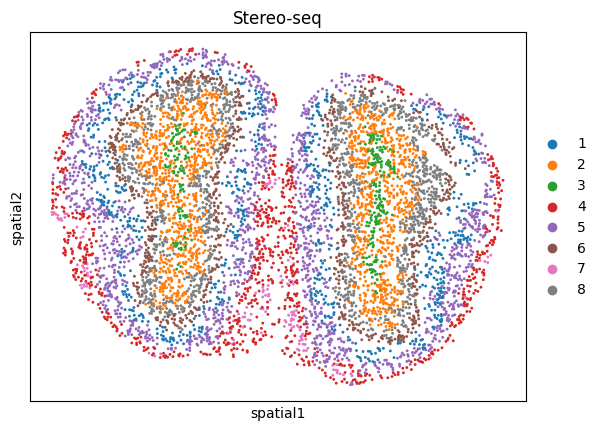

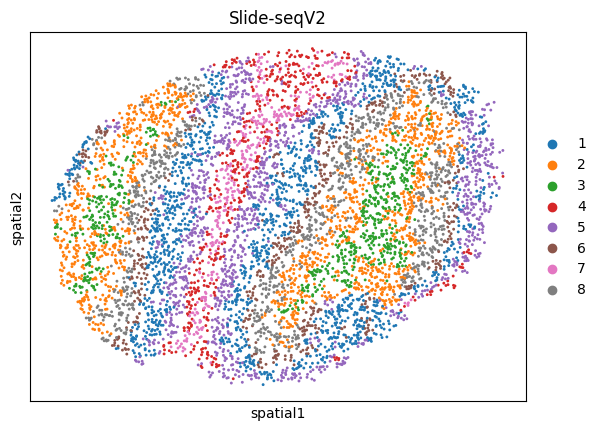

In [4]:
staig.cluster(args.label)
label = staig.adata.obs['domain'].values
data1.obs['domain'] = label[:7000]
data2.obs['domain'] = label[7000:]
sc.pl.embedding(data1, basis="spatial", color="domain",show=True,title='Stereo-seq')
sc.pl.embedding(data2, basis="spatial", color="domain",show=True,title='Slide-seqV2')


# UMAP

start umap


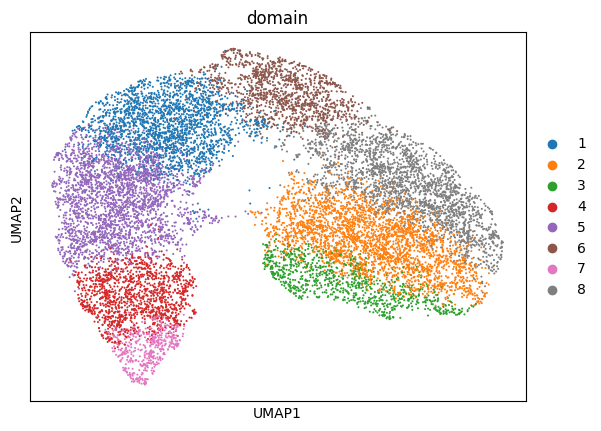

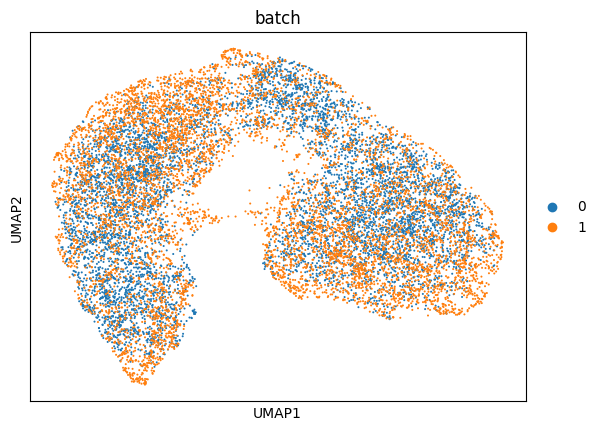

In [5]:
staig.draw_umap()